## Linear Supervised Learning Series

# Part 5: One-versus-all multiclass classification

In practice many classification problems have more than two classes we wish to distinguish, e.g., face recognition, hand gesture recognition, general object detection, speech recognition, and more.


In the next two posts we discuss two popular generalizations of the two class framework discussed previously for multiclass classification - namely, *One-versus-All* and *multiclass logistic regression* (the latter of which is also referred to as *multiclass softmax classification* or *softmax regression*).  For a dataset consisting of $C$ classes both schemes learn $C$ two class linear classifiers - each of which distinguishes a single class from all others - fusing them together to create multi-class classifier.  These two popular approaches fuse the $C$ linear classifiers together in essentially the same manner, differing only in how the individual classifiers are trained: in the One-versus-All scheme each classifier is trained independently from the others, while with multiclass logistic regression all are tuned simultaneously.  Akin to say logistic regression versus support vector machines, both multiclass methods are commonly used and perform similarly in practice.

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  One-versus-All multiclass classification 

Because it has only two sides, a single linear separator is fundamentally insufficient as a mechanism for differentiating between more than two classes of data. However we can use our understanding of two-class classification to overcome this shortcoming when dealing with $C>2$ classes by learning $C$ linear classifiers (one per class), each distinguishing one class from the rest of the data.  The trick of the matter is how we should combine these individual classifiers to create a reasonable multiclass decision boundary.  We will develop this scheme step-by-step by studying how such an idea should unfold on a toy dataset.  With due diligence and a little common sense we can intuitively derive universal ideas regarding multi-class classification that are the basis for most popular multiclass classification schemes, including One-versus-All (OvA) classification.

## 1.1 Multiclass data

A multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consists of $C$ distinct classes of data.  As with the two-class case we can in theory use any $C$ distinct labels to distinguish between the classes, but for future derivations it is convenient use label values $y_{p}\in\left\{ 1,2,...,C\right\} $.  The next Python cell loads in and plots the $C = 3$ class dataset we will use in our derivation of OvA.  Afterwards we will apply what we have developed to other datasets as well.

<IPython.core.display.Javascript object>


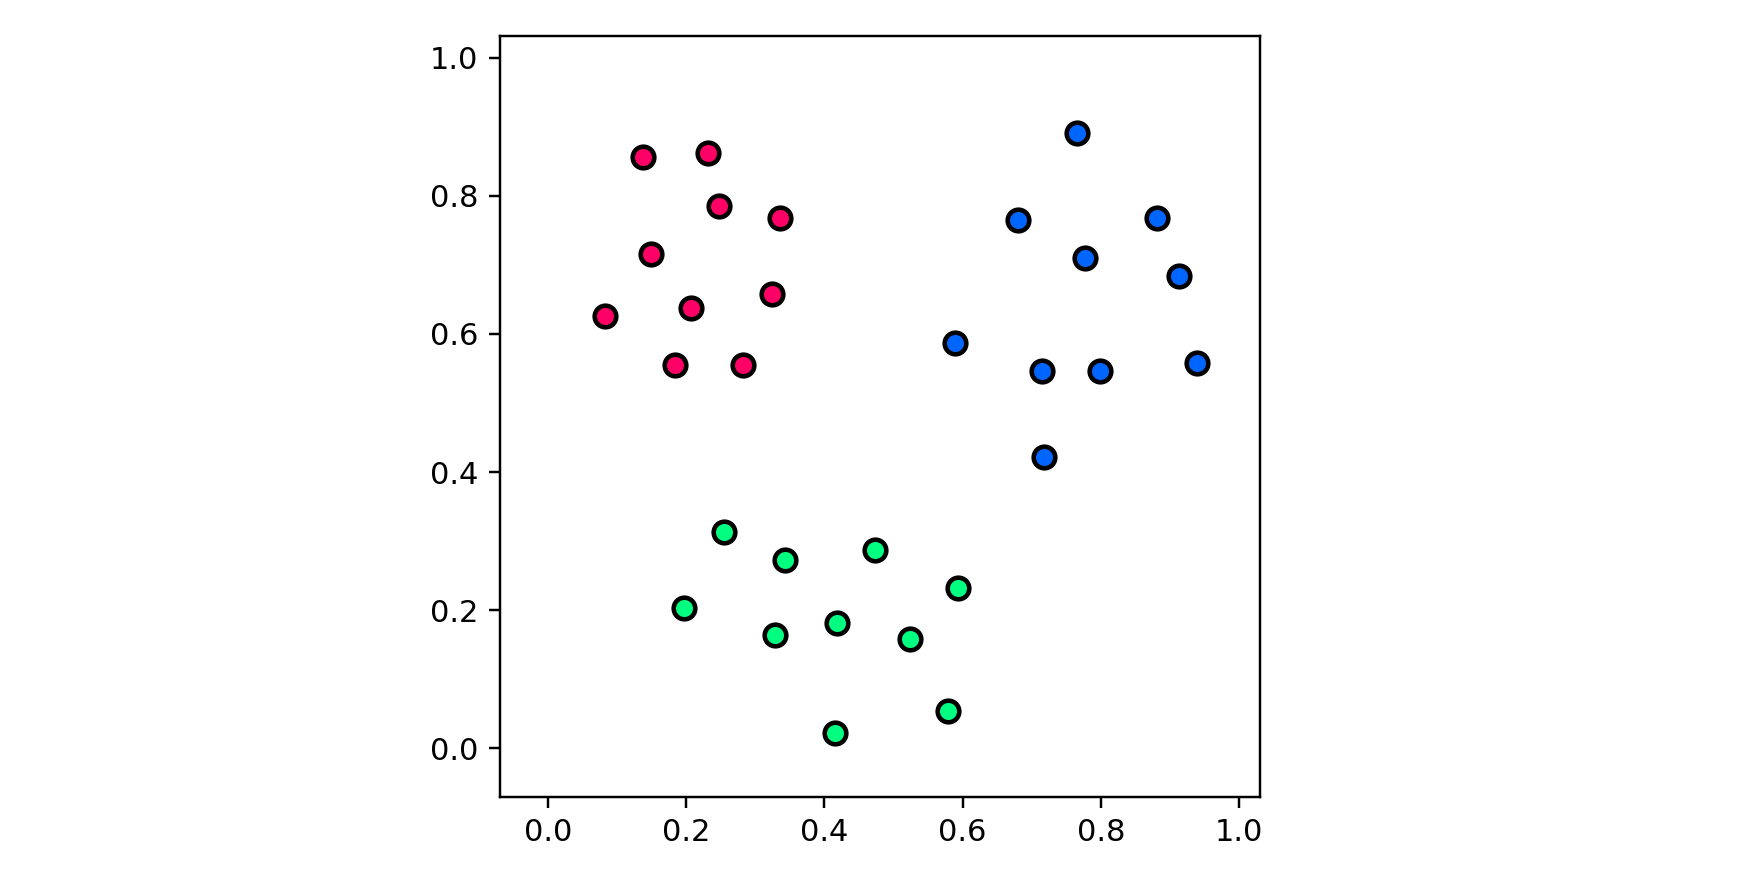

In [8]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo1 = superlearn.ova_illustrator.Visualizer(data)

# visualize dataset
demo1.show_dataset()

##  1.2  Training  $C$ one-versus-all classifiers

The first step of OvA classification is simple - we reduce the new problem of multiclass classification into a sequence of smaller problems that we are already familiar with.  If we reflect for a moment on what we want, one way of phrasing the goal of multiclass classification is that *we want to learn how to distinguish each class of our data from the other $C-1$ classes*.  From this perspective it certainly seems that a good first step towards accomplishing our goal would be to learn $C$ two-class classifiers on the entire dataset, with the $c^{th}$ classifier trained to distinguish the $c^{th}$ class from the remainder of the data.  With the $c^{th}$ two-class subproblem we simply assign temporary labels $\tilde y_p$ to the entire dataset - giving $+1$ labels to the $c^{th}$ class and $-1$ labels to the remainder of the dataset i.e.,

\begin{equation}
\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if} y_p = c \\ -1 \,\,\,\,\,\,\text{if} y_p \neq c    \end{cases}
\end{equation}

where again $y_p$ is the original label for the $p^{th}$ point, and run the two-class classification scheme of our choice.

Doing this for our $C = 3$ dataset we end up learning 3 linear classifiers - here we use logistic regression for each subproblem, solving each using Newton's method.  This is performed by activating the next Python cell.

In [3]:
# solve the 2-class subproblems
demo1.solve_2class_subproblems()

With our classifiers trained we can now illustrate our learned decision boundaries - each learned to distinguish a single class from the remainder of the data.  The next Python cell plots two rows of images - in the top row our original dataset is plotted three times with each instance showing just one of the three two-class classifiers learned.  The single class being distinguished is colored with its original color - with the corresponding learned decision boundary colored similarly - and all other data is colored gray.  In the bottom row the dataset is shown with along with all three learned decision boundaries.

<IPython.core.display.Javascript object>


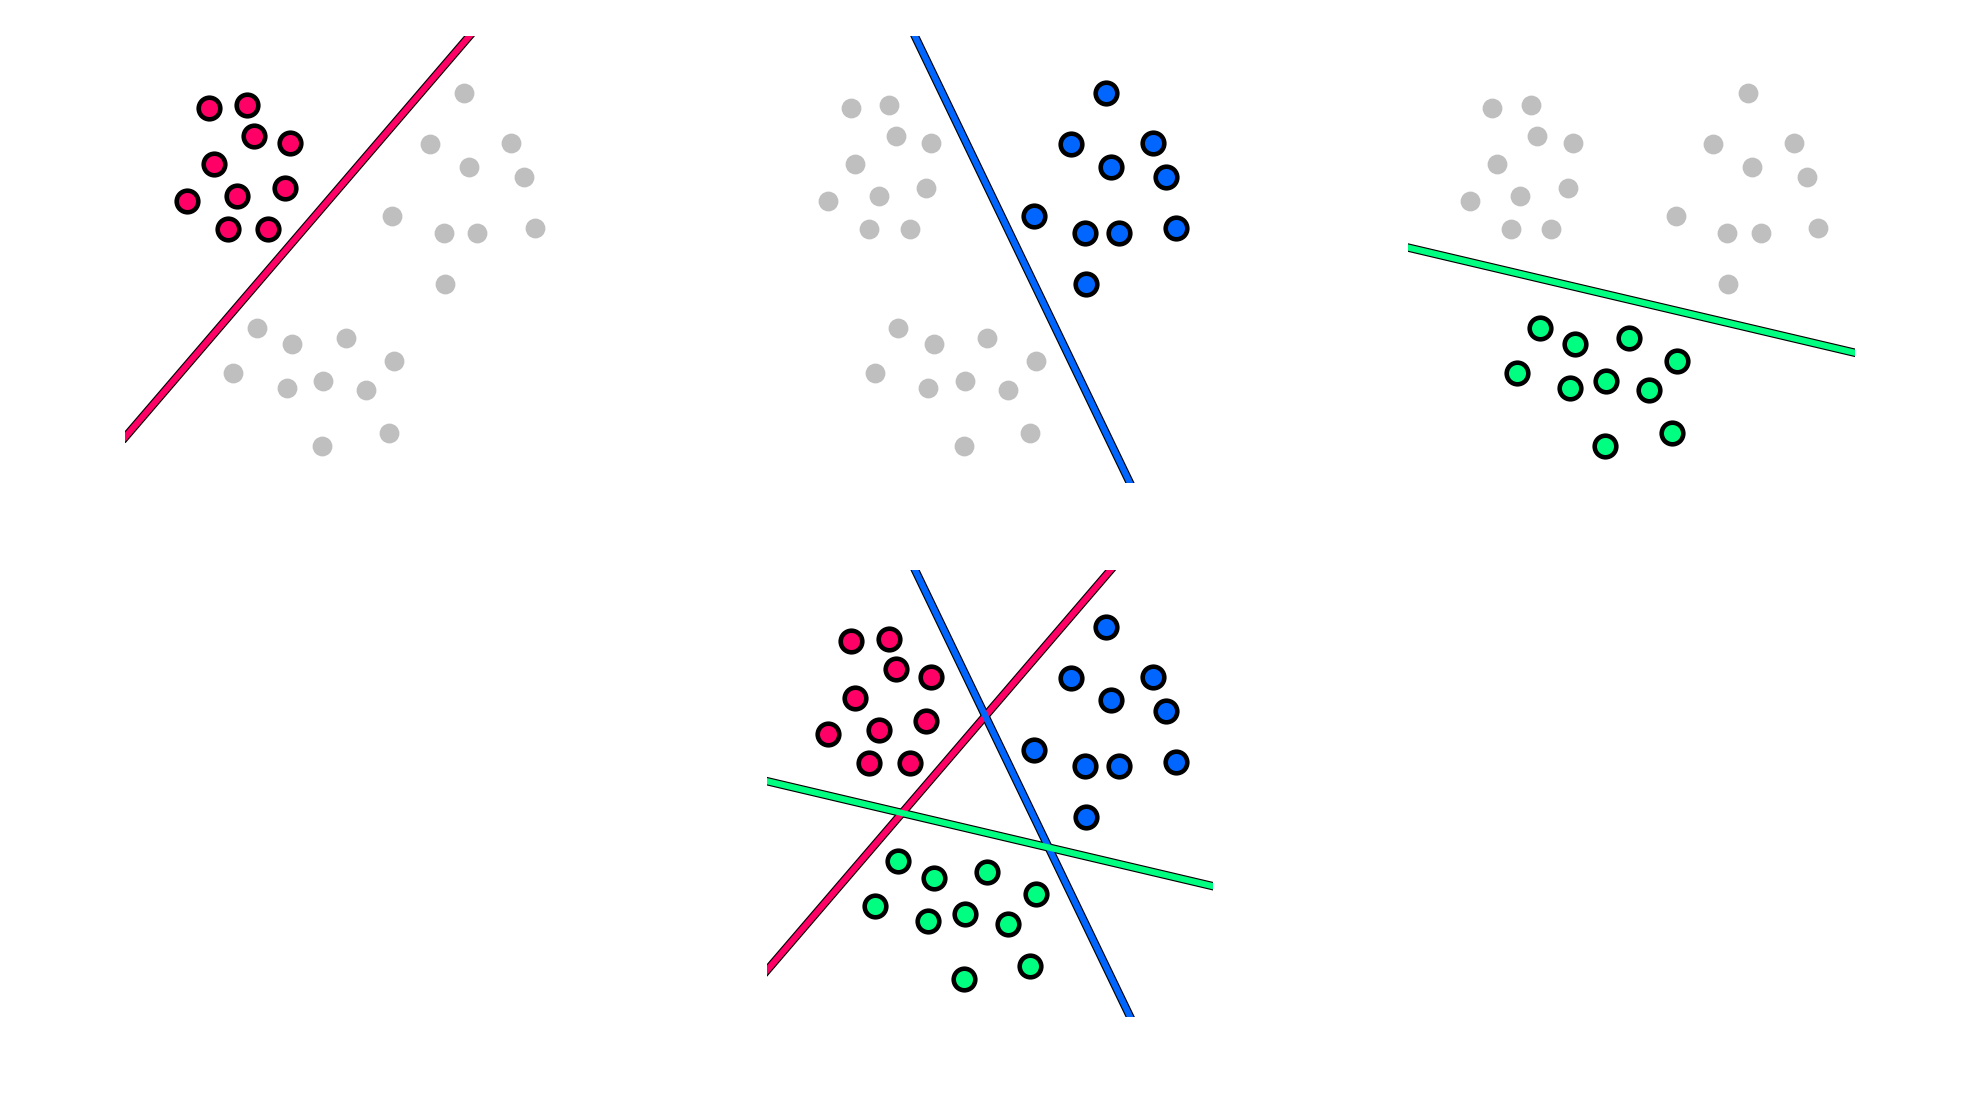

In [14]:
# illustrate dataset with each subproblem and learned decision boundary
demo1.plot_data_and_subproblem_separators()

## 1.3  Points on the positive side of a single classifier

Now we have learned $C$ two-class classifiers, learning the bias/slope weights  $\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right)\,\left(w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)}\right),,...,\left(w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}\right)$ respectively - the $C$ associated linear decision boundaries the $c^{th}$ of which can be written as

\begin{equation}
w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = 0
\end{equation}

Note in the figure above how in each case that - because each subproblem is perfectly linearly separable and because of our choice of temporary labels - that the class to be distinguished from the rest lies on the *positive side* of its respective classifier, with the remainder of the points lying on the *negative side*.  This of course means that for the $c^{th}$ classifier we have for the $p^{th}$ point $\mathbf{x}_p$ that

\begin{equation}
w_0^{(c)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(c)} =  \begin{cases}   > 0 \,\,\,\,\,\,\text{if}\,\,\, y_p = c  \\ < 0 \,\,\,\,\,\, \text{if} \,\,\, y_p \neq c.    \end{cases}
\end{equation}

Another way of saying this that - when evaluated by each two-class classifier individually - the one learned to a point's true label always provides the largest evaluation i.e.,

\begin{equation}
w_0^{(c)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}


So we know how to classify the points that we have, what about those we do not?  How do we classify arbitrary points in the space of our example?  Lets figure this out step-by-step.  

First, those points that lie solely on the positive side of the $c^{th}$ classifier only - like the points we already have - should clearly belong to the $c^{th}$ class.  Such a point $\mathbf{x}$ lies close to those we already have, also clearly satisfying the condition that 

\begin{equation}
w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

Therefore to get the associated label $y$ we therefore want the *maximum argument* of the right hand side - since this gives the index associated with the largest classifier.  Formally then the predicted label $y$ for input point $\mathbf{x}$ here can be written as

\begin{equation}
y =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

We color in the points representing these areas of the space of our dataset in via the Python cell below.  

<IPython.core.display.Javascript object>


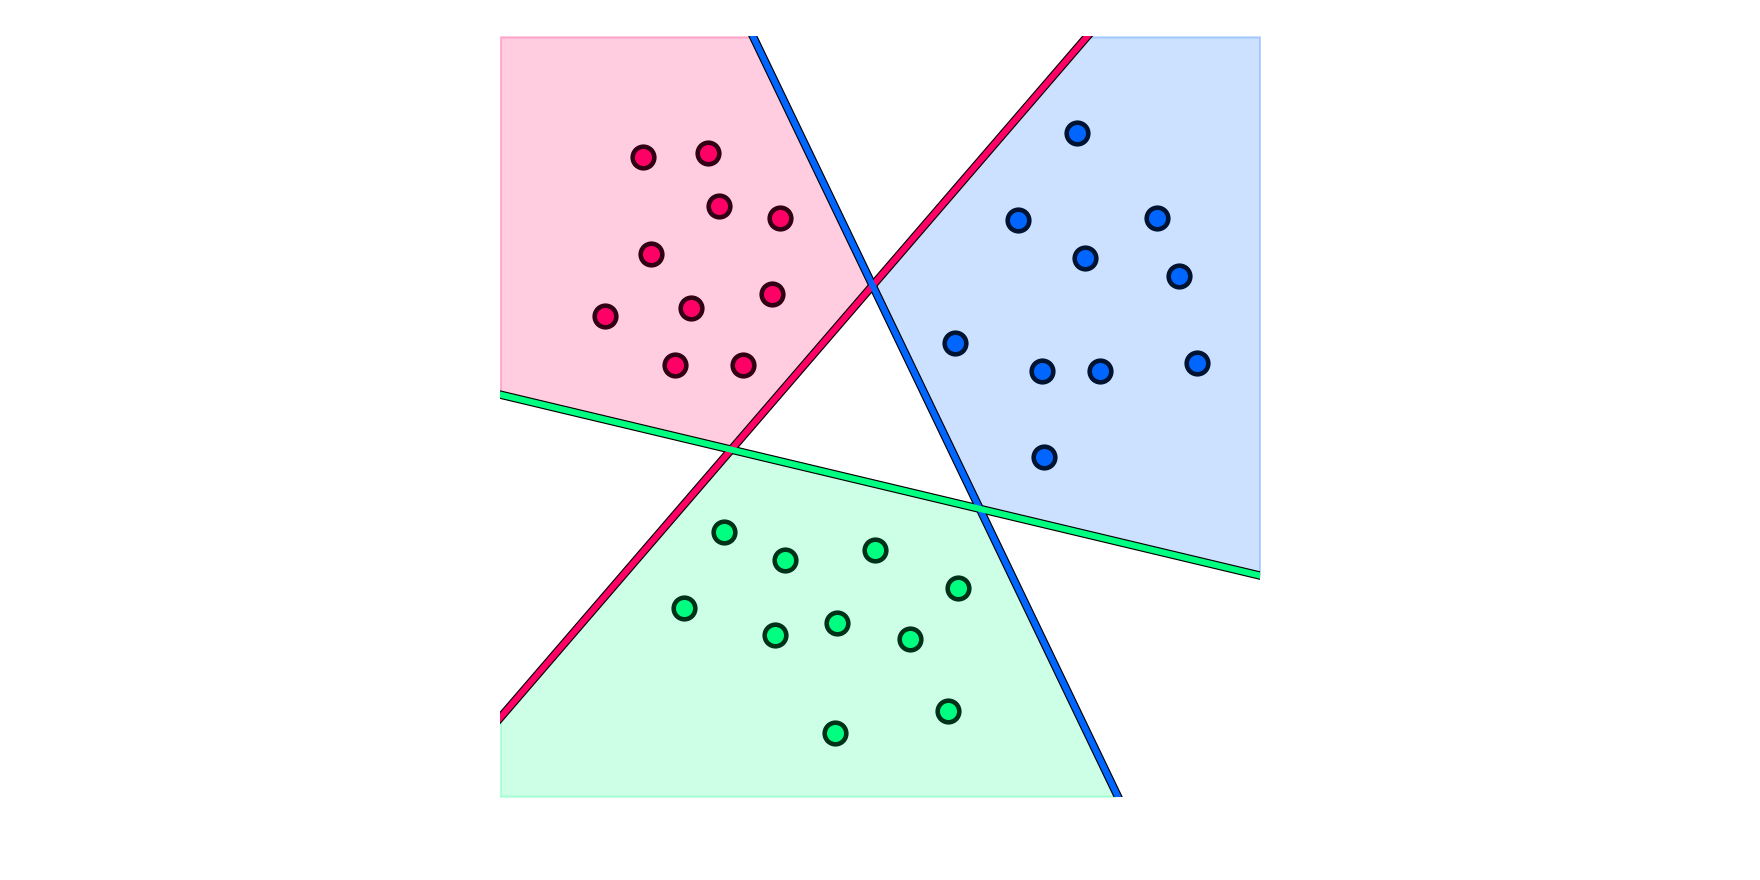

In [4]:
# color those points clearly belonging to each individual class - those lying near the points we already have on the positive side of only one classifier.
demo1.show_fusion(region = 1)

## 1.4  Points on the positive side of more than one classifier

Notice the regions left uncolored above, that do not fall into this first category (of being on the positive side of a single classifier).  These include regions where points are on the positive side of more than one classifier - these are the three triangular white regions bordered by *two* decision boundaries.  For example points in the white region at the top - bordered by the red and blue decision boundaries - are on the positive side of both the red and blue classifiers.  The un-colored regions also include the one in the very middle of the plot - whose points are on the negative side of all three classifiers.

Let us first determine how to appropriately classify points in those un-colored regions where more than one classifier is positive, and for simplicity lets look at the top region that is on the positive side of both the red and blue classifiers (the other regions should behave similarly).

Lets look at two example points in this region - as shown by the Python cell below.  In each case we plot the original dataset and individual classifiers along with new point in question in black.  We also highlight the distance from the new point to both decision boundaries in dashed black, with the projection of the point onto each decision boundary shown as an 'X' in the same color as its respective hyperplane.  Which class should we assign each point too?

<IPython.core.display.Javascript object>


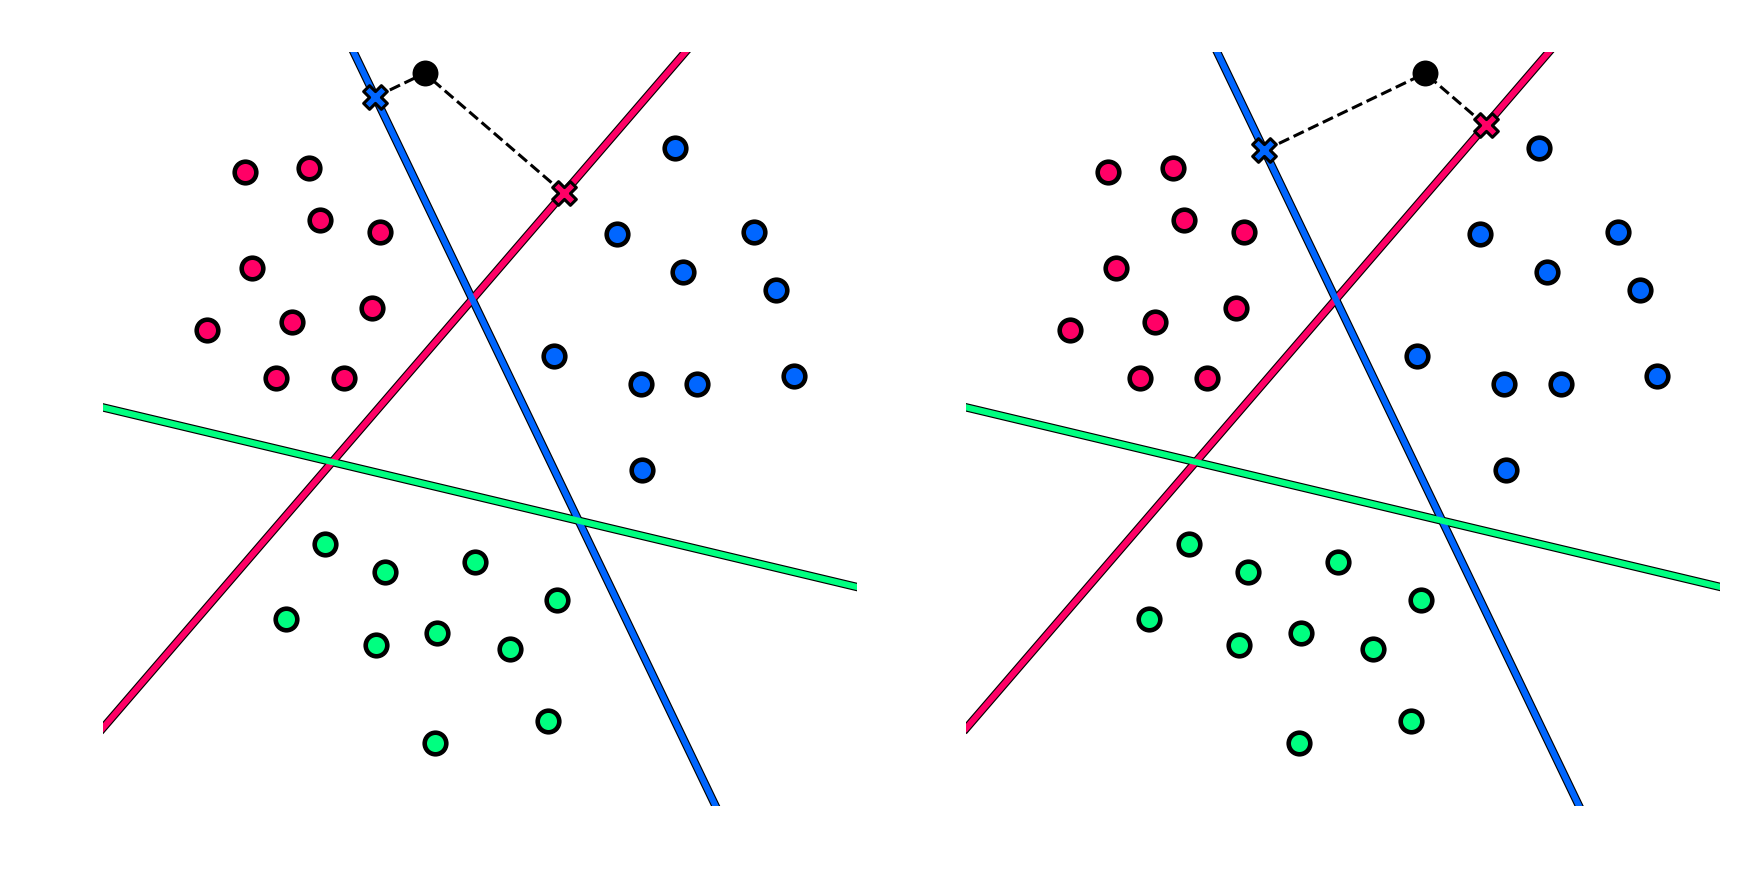

In [89]:
# try examining a point and its distance to relevant decision boundaries
demo1.point_and_projection(point1 = [0.4,1] ,point2 = [0.6,1])

Beginning with the point shown on the left - which class should we assign this point too?

Recall that when we discussed logistic regression that we think of a classifier as being 'more confident' of the class identity of given a point the *farther* the point lies from the classifier's decision boundary.  This is a simple geometric / probabilistic concept, the bigger a point's distance to the boundary the deeper into one region of a classifier's half-space it lies, and thus we can be much more confident in its class identity than a point closer to the boundary.  Another way we can think about it - imagine if we slightly perturbed the decision boundary: those points originally close to its boundary might end up on the other side of the perturbed hyperplane, changing classes, whereas those points farther from the boundary are less likely to be so affected (hence we can be more confident in their class identities to begin with).

With this in mind - which classifier can we say is more confident about this point?  The red one - our input point lies a greater distance from it, and since the point is on the positive side of both classifiers we can say that the point is better assigned to the red class of points.m  

What about the point shown in the right panel?  By the same logic it is best assigned to the blue class, being a greater distance from the blue classifier.

If we repeat this logic for every point in the region - as well as those points in the other two regions where two or more classifiers are positive - and color each point the color of its respective class, we will end up shading each such region as shown by the Python cell below.

<IPython.core.display.Javascript object>


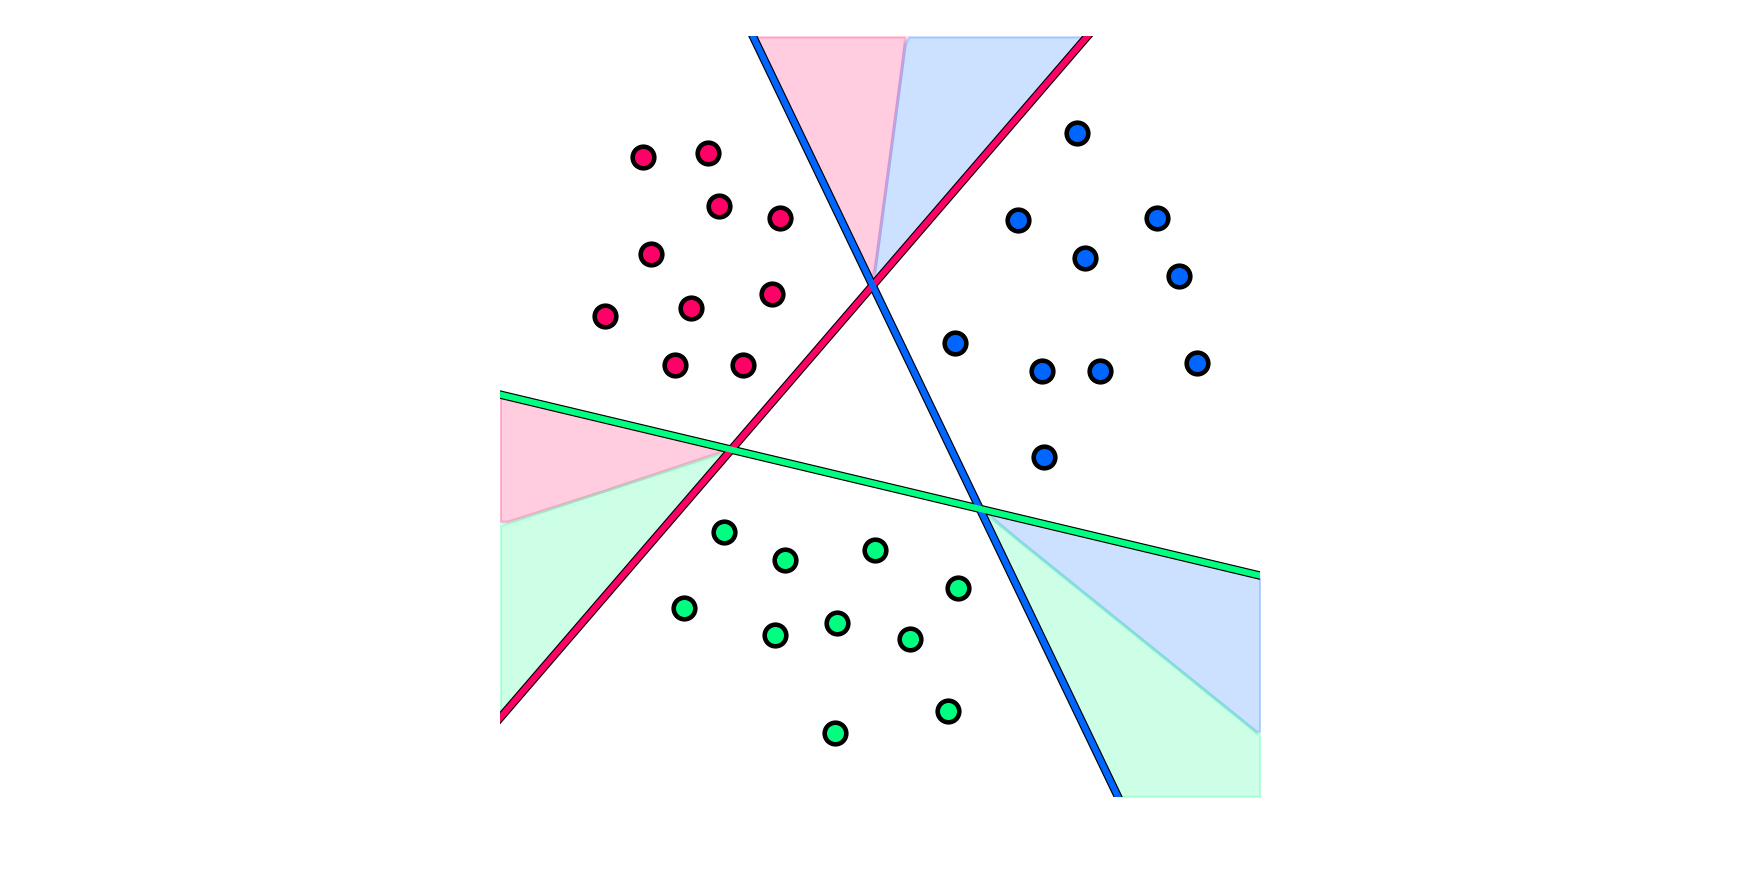

In [88]:
# color points belonging on the positive side of two or more classifiers
demo1.show_fusion(region = 2)

And how do those points equi-distant to two or more decision boundaries get assigned to a class?  In the same way points lying on a two-class decision boundary do e.g., we assign a class label at random.  These points form the *multiclass decision boundary*.

How do we formalize this rule?  In these regions we have assigned each point to the class whose boundary it is the *largest* distance from.  The signed distance of an arbitrary point $\mathbf{x}$ to the $c^{th}$ linear decision boundary (this was first discussed in our post on logistic regression) is given as 

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $c^{th}$ boundary} =  \frac{w_0^{(c)} + \mathbf{x}_{\mathstrut}^T \mathbf{w}_{\mathstrut}^{(c)}}{\mathbf{w}_{\mathstrut}^{(c)}}.
\end{equation}

If we *normalize* the weights of each linear classifier by the length of the normal vector

\begin{equation}
w_0^{(c)} \longleftarrow \frac{w_0^{(c)}}{\left\Vert \mathbf{w}_{\mathstrut}^{(c)} \right\Vert_2}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \mathbf{w}_{\mathstrut}^{(c)} \longleftarrow \frac{w_0^{(c)}}{\left\Vert \mathbf{w}_{\mathstrut}^{(c)} \right\Vert_2}
\end{equation}

then this distance is simply written as 

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $c^{th}$ boundary} =  w_0^{(c)} + \mathbf{x}_{\mathstrut}^T \mathbf{w}_{\mathstrut}^{(c)}.
\end{equation}

Then to assign a point in one of our current regions we seek out the classifier which *maximizes* this quantity.  In other words the $c^{th}$ classifier where $w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}$.  Notice that this means that the actual predicted label $y$ of the input point $\mathbf{x}$ is given as the argument here.  That is we have found that - after weight-normalizing - we have precisely the same prediction rule we found originally for regions of the space where only a single classifier is positive

\begin{equation}
y =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

So the same rule above can be used in any region of the space where at least one classifier is positive.

## 1.5  Points on the negative side of classifiers

Finally, what about the middle blank region of our dataset - where all of our classifiers are negative?  How shall we assign class labels to these points.  Once again let us examine two points in this region and reason out what should be done.

<IPython.core.display.Javascript object>


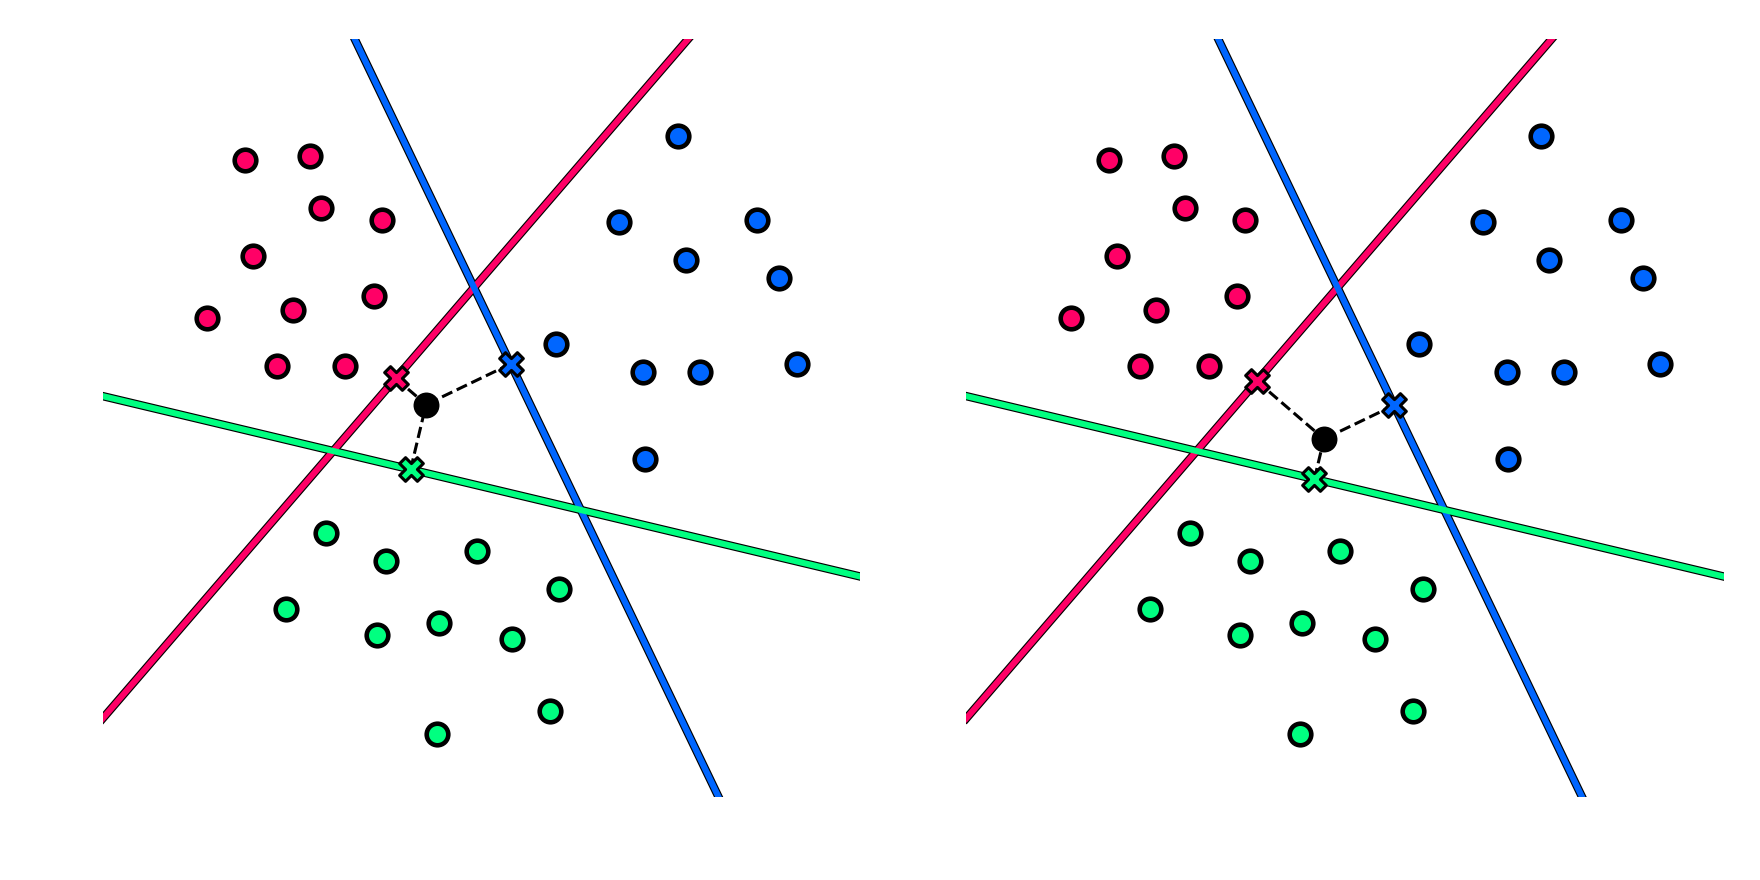

In [99]:
# try examining a point and its distance to relevant decision boundaries
demo1.point_and_projection(point1 = [0.4,0.5] ,point2 = [0.45,0.45])

Lets start with the point on the left.  This point, like all those in the middle region, are on the negative side of all our classifiers.  In other words, when trained each of our '$c^{th}$ class versus not $c$ class' two-class classifiers designated these points as 'not in $c$'.  Thus we cannot argue - as we did at points on the positive side of multiple classifiers - that one classifier is more 'confident' in the class identity of such points.  So what about the opposite question - which classifier is the least 'unsure' about the class identity of this point?  Which class is the point the least dissimilar spatially given our decision boundaries?  *Not* the boundary it is furthest from as was the case previously, but the one it is *closest* to.  In the case of our example point on the left it lies closest to the red decision boundary - it is closest to being a red class point - hence we assign it to the red class.  

By the same reason our point on the right - which lies closest to the green decision boundary - is assigned to the green class. 

If we repeat this logic for every point in the region - and color each point the color of its respective class, we will end up shading this region as shown by the Python cell below.

<IPython.core.display.Javascript object>


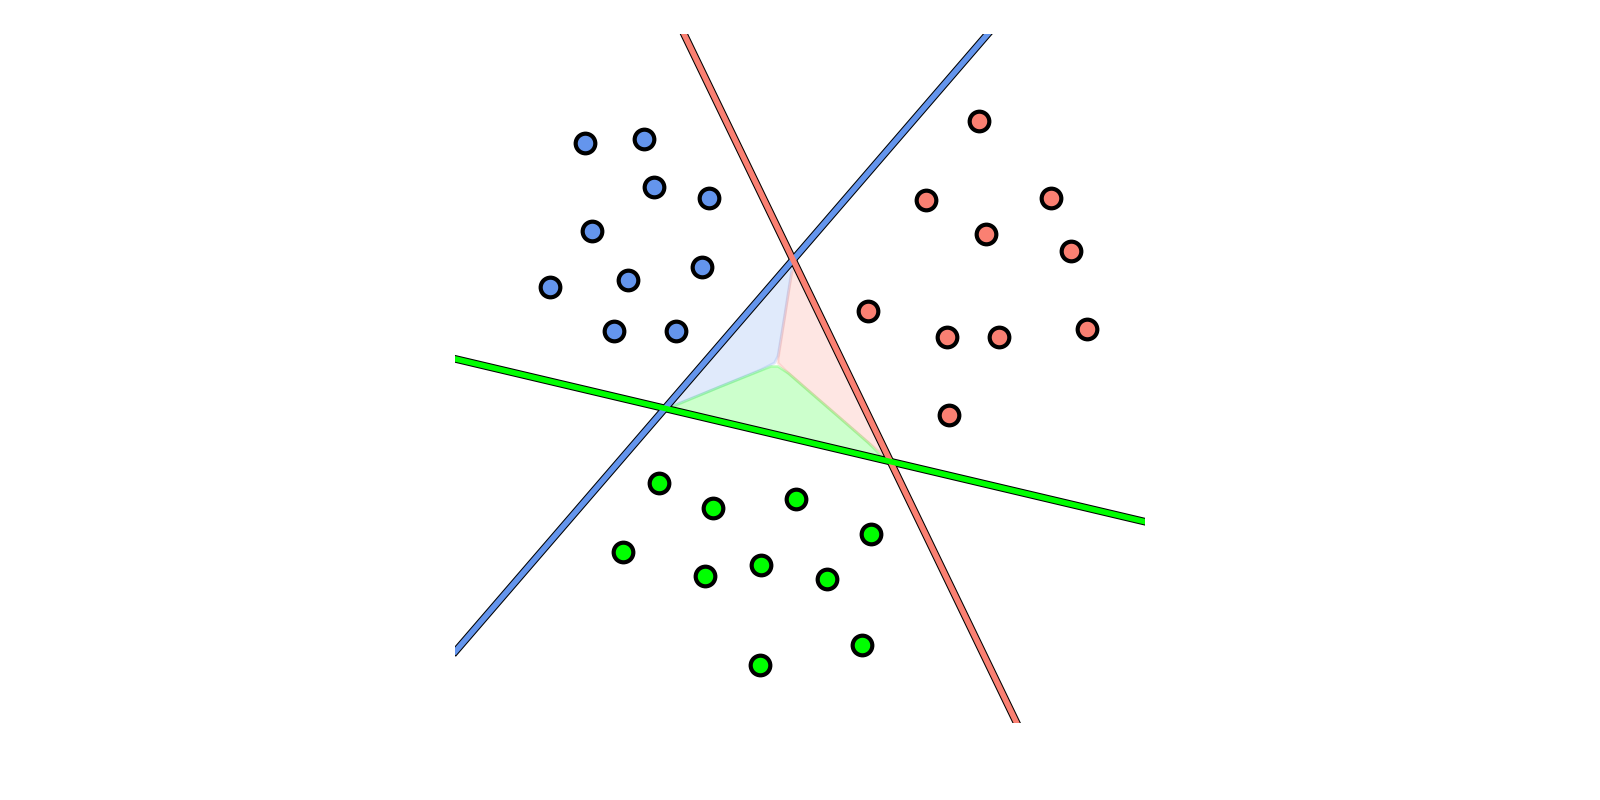

In [59]:
# color the region on which all classifiers are negative
demo1.show_fusion(region = 3)

As in the previous case, those points equi-distant to two or more decision boundaries form the multiclass boundary and are assigned to a relevant class at random.

We can formalize this rule by noting that - once again - our reasoning has led us to assign a point to the class whose boundary it is the largest signed distance away from.  Every point in the region lies on the negative side of our classifiers all signed distances are negative.   Hence the shortest distance *in magnitude* is the largest *signed* distance, being the smallest (in magnitude) negative number.  Conversely the largest distance *in magnitude* is the largest (in magnitude) negative number, and hence the smallest *signed* distance.  

Thus once again we find that (since the weights of our classifiers have been normalized) for an input point $\mathbf{x}$ that the classifier providing the maximum signed distance given by $w_0^{(c)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(c)} = \underset{j=1,...,C}{\text{max}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}$ provides the corresponding predicted label $y$

\begin{equation}
y =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

## 1.6  Putting it all together

We have now deduced that the single rule for assigning a label $y$ to a point $\mathbf{x}$ 

\begin{equation}
y =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}.
\end{equation}

which says to assign the label based on the maximum signed distance of this point to each classifier, applies to the entire space of our problem (and - in general - to any multiclass problem).  In fact this rule not only applies to the toy $C = 3$  dataset we have used in deriving the rule here, but to all multiclass datasets.  Indeed we could have used any dataset (even those that are not completely separable) in our derivations here, as any multiclass problem can be broken down into the three fundamental regions we have seen in these derivations: i.e., regions where points are on the positive side of a single classifier, more than one classifier, or are on the negative side of all classifiers.

We call this the *fusion rule* - since it tells us precisely how to fuse our $C$ individual classifiers together to make a unified and consistent classification across the entire space of any dataset.  It is the core of the *One-versus-All* algorithm, which we now state formally.

### One-versus-All  multiclass classification

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; **Input:** multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$ where $y_{p}\in\left\{ 1,2,...,C\right\}$, two-class classification scheme and optimizer <br>

<strong>2:</strong>&nbsp;&nbsp; Solve two-class sub problems<br>

<strong>3:</strong>&nbsp;&nbsp; <code>for</code> $\,\,c = 1...C$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>form temporary lbaels: </code> $\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if} y_p = c \\ -1 \,\,\,\,\,\,\text{if} y_p \neq c    \end{cases}$ <br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>solve two-class subproblem on </code> $\left\{ \left(\mathbf{x}_{p,}\,\tilde y_{p}\right)\right\} _{p=1}^{P}$ giving weights $\left(w_0^{(c)},\,\mathbf{w}_{\mathstrut}^{(c)} \right)$
<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>normalize weights as </code> $w_0^{(c)} \longleftarrow \frac{w_0^{(c)}}{\left\Vert \mathbf{w}_{\mathstrut}^{(c)} \right\Vert_2}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \mathbf{w}_{\mathstrut}^{(c)} \longleftarrow \frac{w_0^{(c)}}{\left\Vert \mathbf{w}_{\mathstrut}^{(c)} \right\Vert_2}$
<br>

<strong>7:</strong>&nbsp;&nbsp; **output:** normalized weights $\left(w_0^{(1)},\,\mathbf{w}_{\mathstrut}^{(1)} \right)\,\left(w_0^{(2)},\,\mathbf{w}_{\mathstrut}^{(2)}\right),,...,\left(w_0^{(C)},\,\mathbf{w}_{\mathstrut}^{(C)}\right)$ for use with fusion rule: $y =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{\mathstrut}^T\mathbf{w}_{\mathstrut}^{(\,j)}$.<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Having addressed every region in the space of our exemplar dataset, what does the entire space look like when classified?  We plot this in the next Python cell.  In both the left and right panels below we correctly classify and color the entire space as described above.  In the left panel we show the three original two-class linear decision boundaries, and on the right we the multiclass decision boundary (in black) created by fusing these individual boundaries using the fusion rule.  This black multiclass boundary arises at points where the fusion rule does not provide a unique solution - i.e., at points where two or more classifiers provide the maximum evaluation.

Note that while the boundary resulting from the fusion rule is always piecewise-linear, as with our example shown here, while the fusion rule explicitly define this boundary it does not provide us with a closed form formula for it as with e.g., logistic regression (although one may work out a somewhat convoluted formula describing the boundary in general).  In fact the piecewise-linear boundaries shown in the figures of this Section were drawn not by determining their formula but by labeling (and appropriately coloring) every point in the region shown using the fusion rule.

<IPython.core.display.Javascript object>


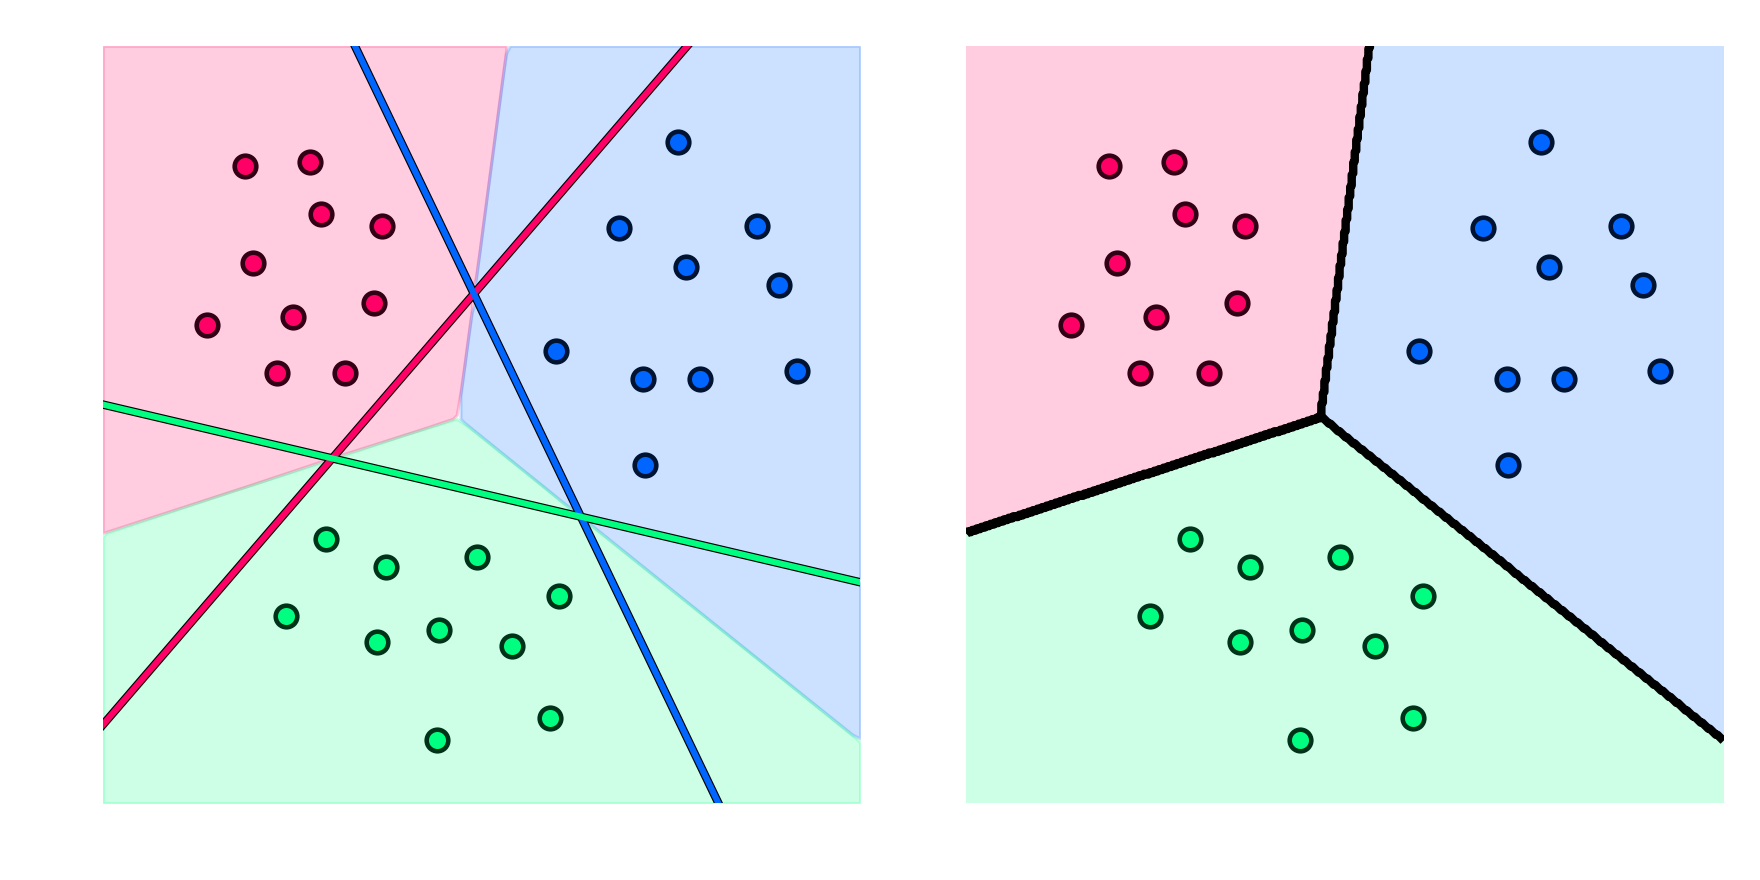

In [14]:
# classify and color the entire space using our individual classifiers and the fusion rule
demo1.show_complete_coloring()

#### <span style="color:#a50e3e;">Example 1: </span> An example $C = 4$ class dataset

In this example we quickly apply the OvA algorithm derived above to a toy $C = 4$ class dataset shown below.

<IPython.core.display.Javascript object>


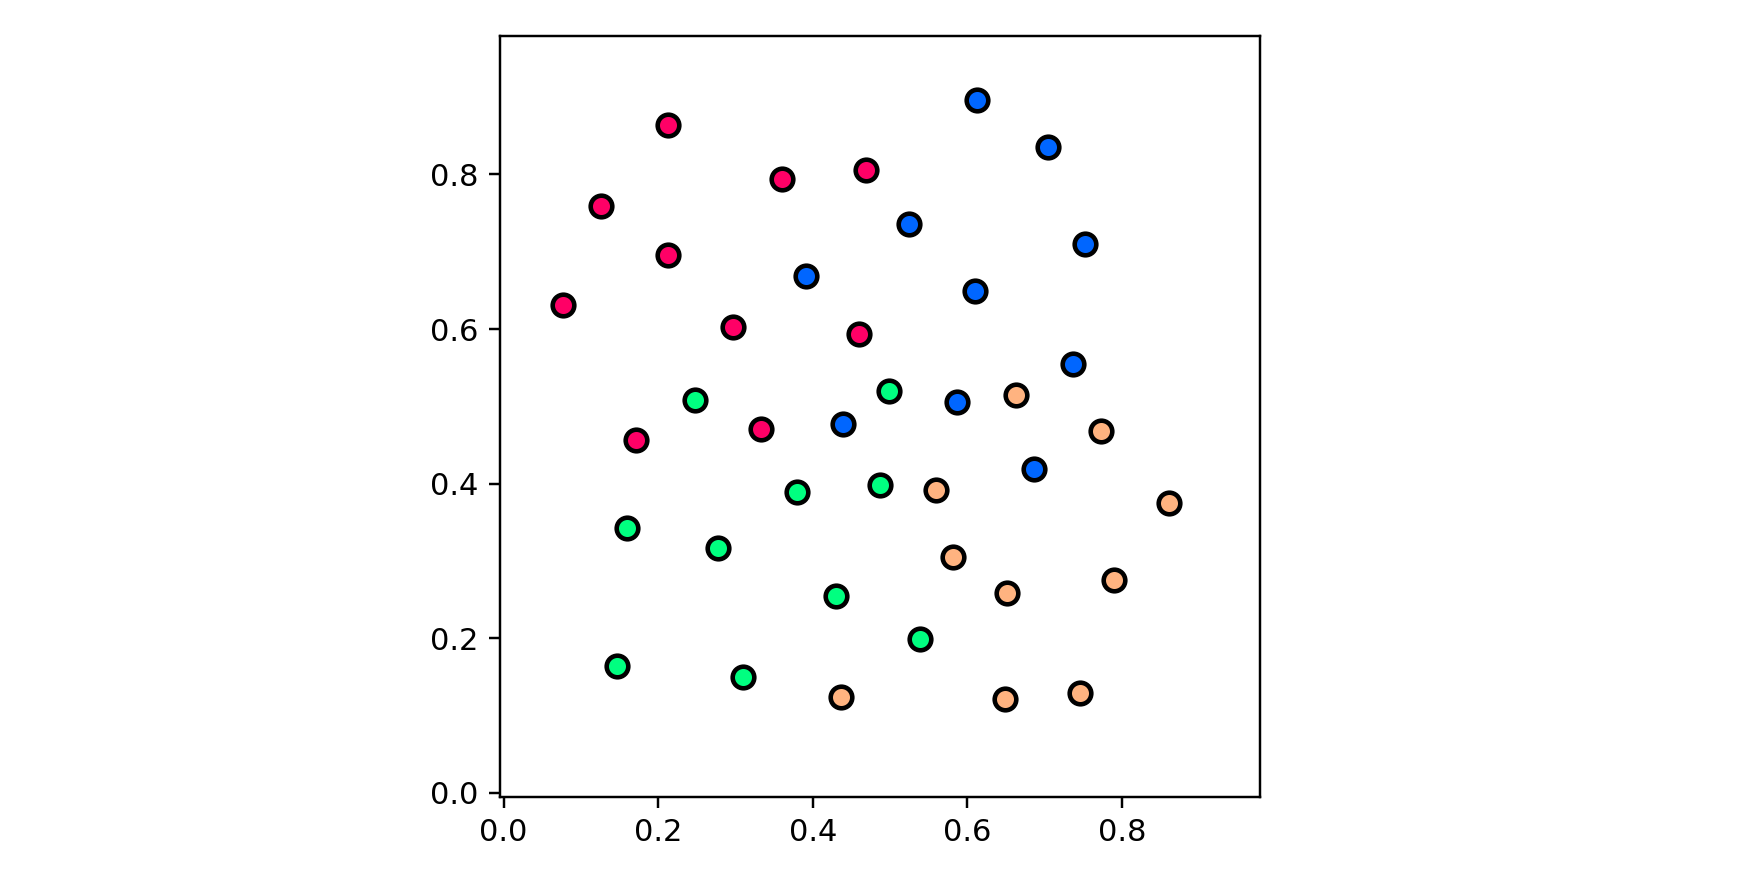

In [11]:
# load in dataset
data3 = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/4class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo3 = superlearn.ova_illustrator.Visualizer(data3)

# visualize dataset
demo3.show_dataset()

Note with this dataset that each class is *not* linearly separable from the remainder of the data.  This is no matter - the OvA framework still produces an appropriate multiclass boundary.  We solve our $C$ two-class subproblems below.

In [13]:
# solve the 2-class subproblems
demo3.solve_2class_subproblems()

With our subproblems solved we can use the fusion rule to classify our entire input space.  The Python cell below shows this printing out two panels with all points in the space colored according to the fusion rule in each panel.  The left panel also shows the individual learned two-class classifiers, while the right panel shows the final multiclass decision boundary, which does a fine job of distinguishing the four classes.

<IPython.core.display.Javascript object>


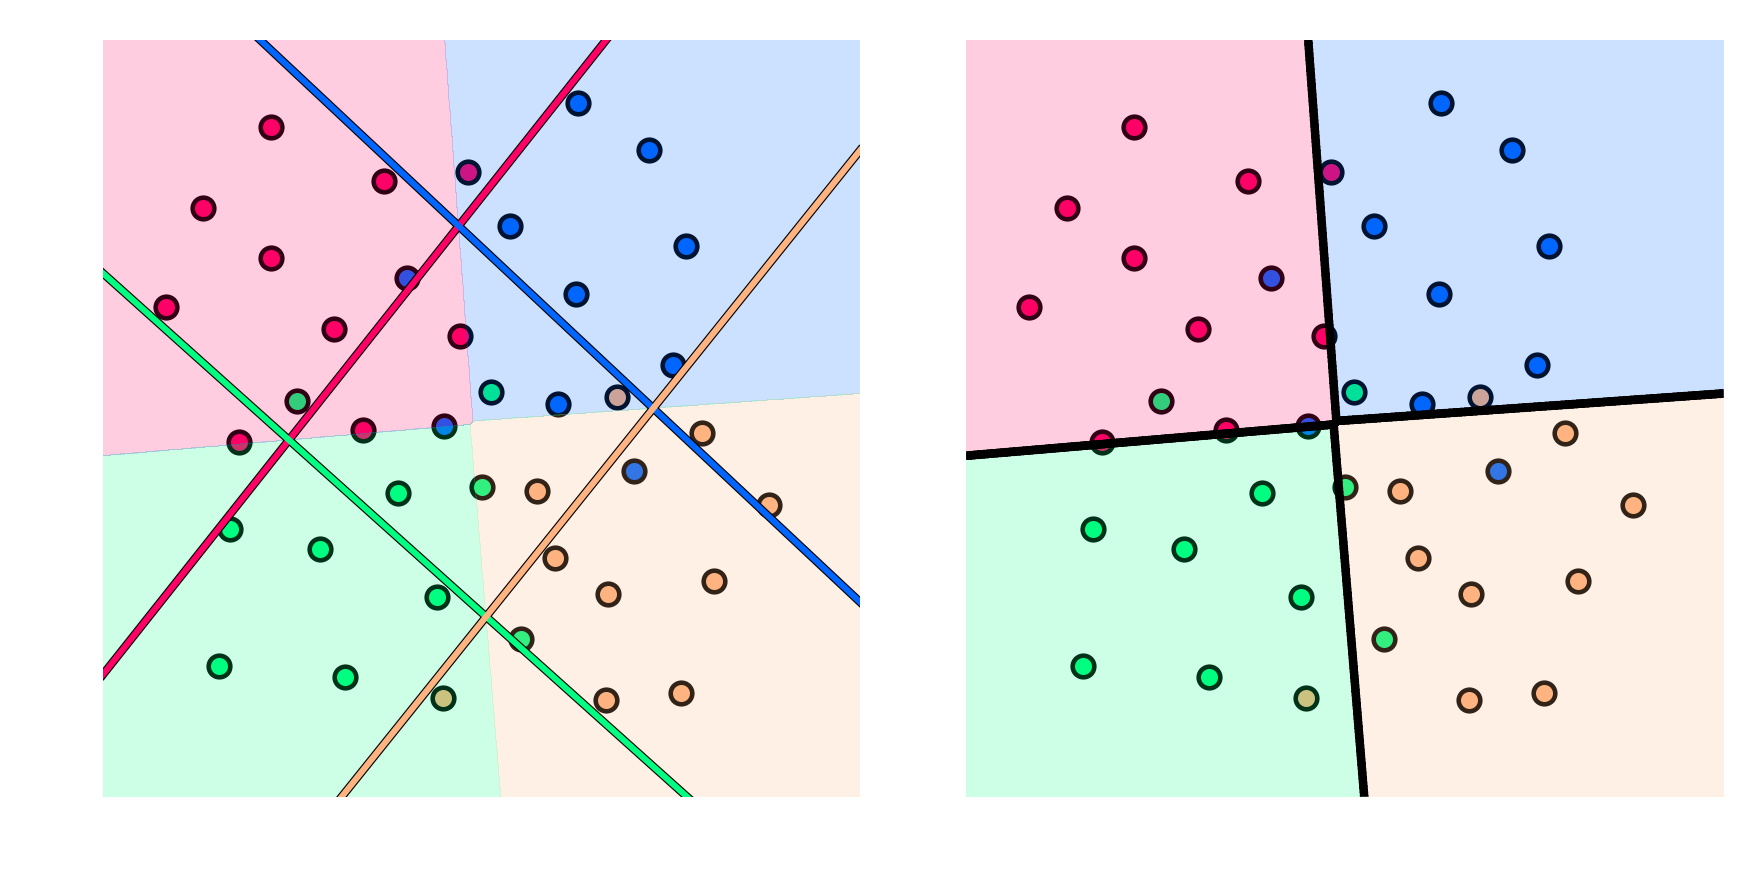

In [14]:
# classify and color the entire space using our individual classifiers and the fusion rule
demo3.show_complete_coloring()

## 1.7  Counting misclassifications and the accuracy of a multiclass classifier

Once trained we can compute predicted labels for our training set by simply evaluating each input via the fusion rule.  Taking the input of the $p^{th}$ point $\left(\mathbf{x}_p,\,y_p\right)$ we use the fusion rule to produce a predicted output $\hat y_p$ as

\begin{equation}
\hat y_p =  \underset{j=1,...,C}{\text{argmax}} \,\,\,w_0^{(\,j)} + \mathbf{x}_{p}^T\mathbf{w}_{\mathstrut}^{(\,j)}
\end{equation}

and then simply compare the actual and predicted labels to understand if our prediction is correct.  One way to write this comparison is $\left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p} \right) \right |$, which is $0$ if the prediction matches the true label and $+1$ otherwise.  We can then write the total number of misclassifications on our training set as

\begin{equation}
\text{number of misclassifications on training set } = \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}

with the accuracy being then calculated as 

\begin{equation}
\text{accuracy of learned classifier} = 1 - \frac{1}{P} \sum_{p = 1}^{P} \left | \text{sign}\left(\hat y_p - \overset{\mathstrut}{y_p}\right) \right |
\end{equation}